# Train RetinaNet model on CMCT-ODAEL data set

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.sampling import get_slides
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet

path = Path('AblationStudy/databases/')

database = Database()
database.open(str(path/'MITOS_WSI_CMCT_ODAEL_12WSI.sqlite'))

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [2]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, database=database)
            

Loading slides .. : 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]


In [3]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [4]:
bs = 16
train_images = 5000
val_images = 5000
size=256

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))


train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

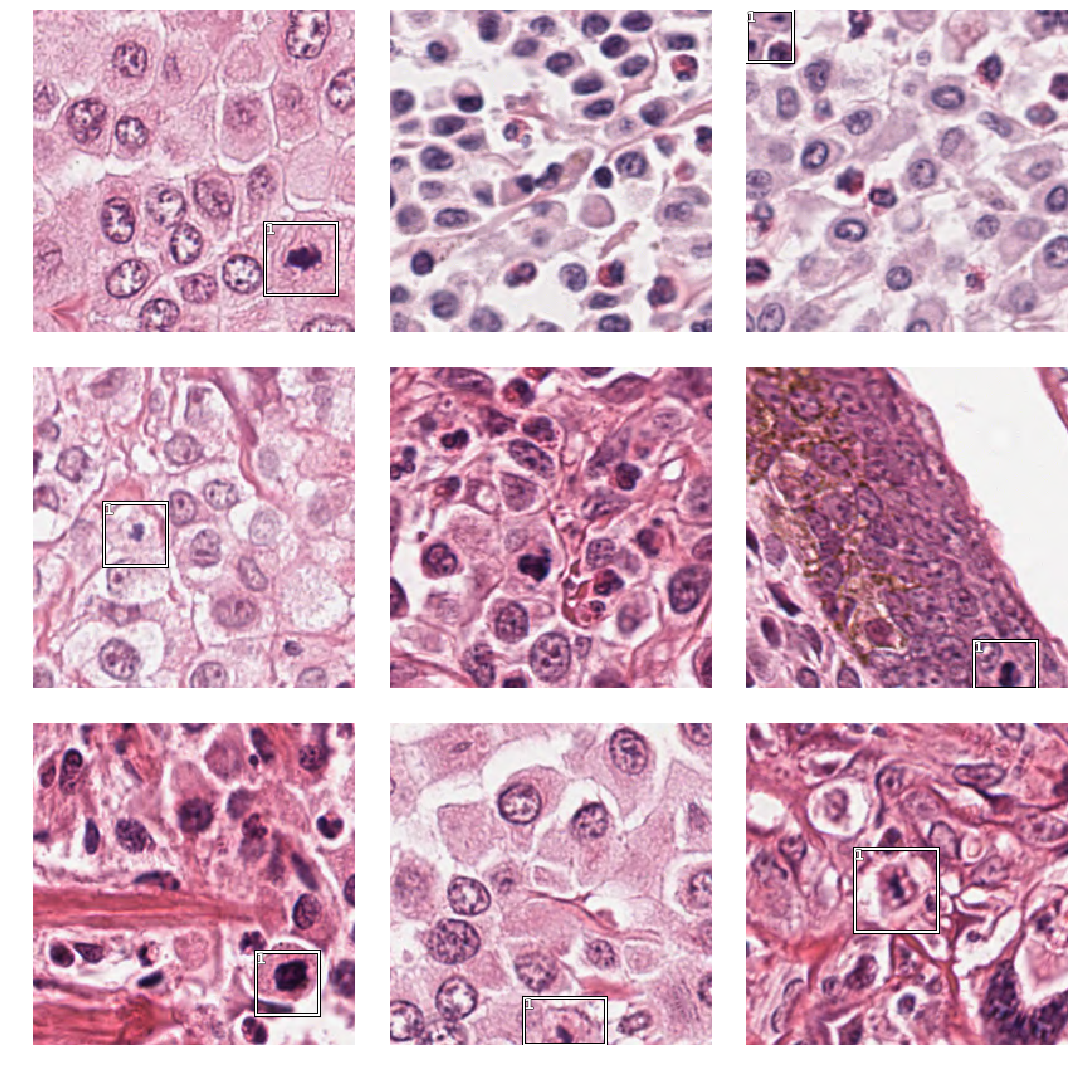

In [5]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

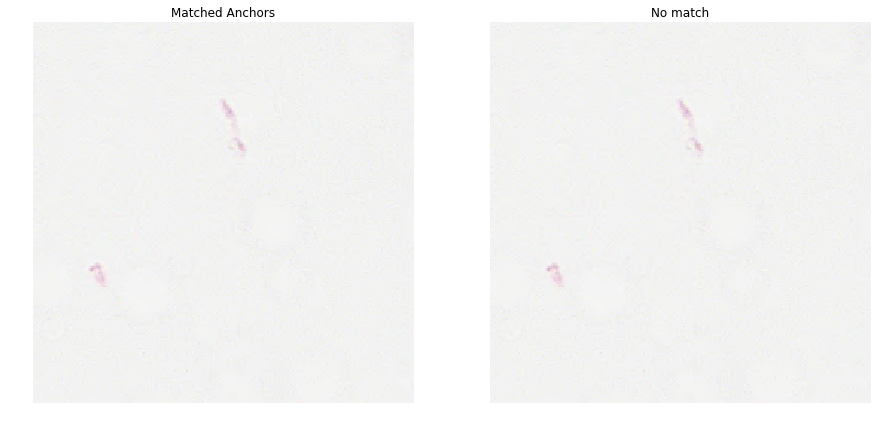

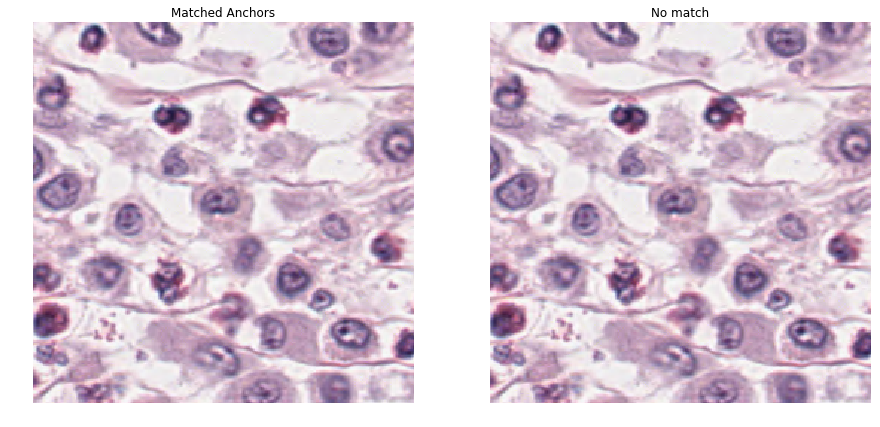

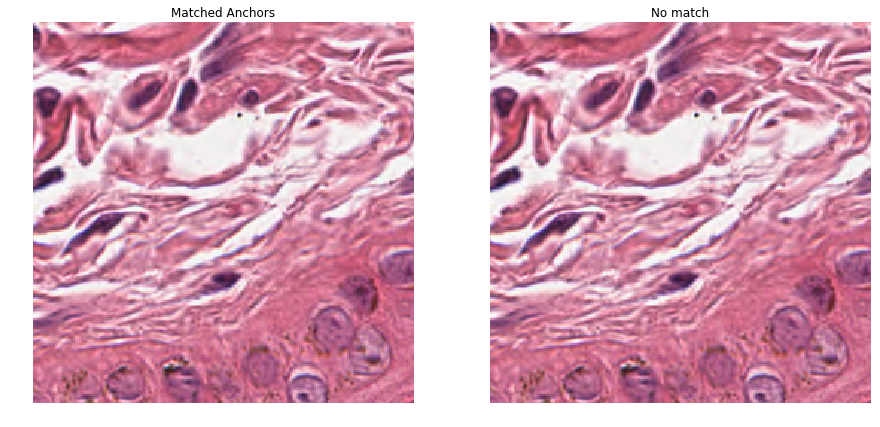

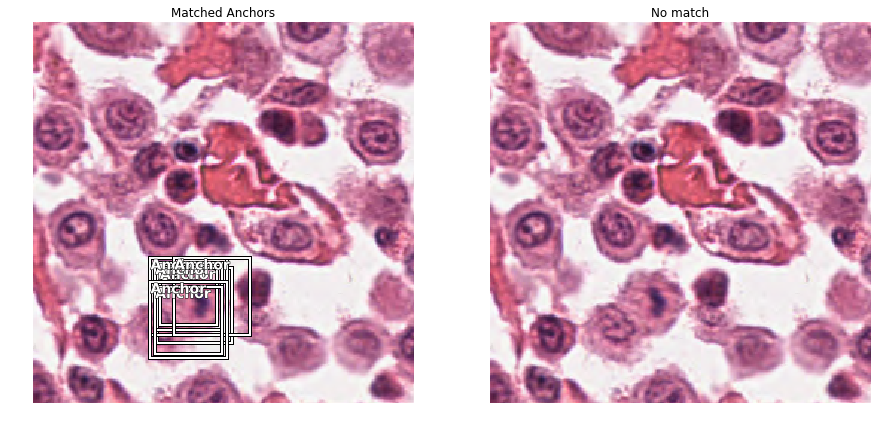

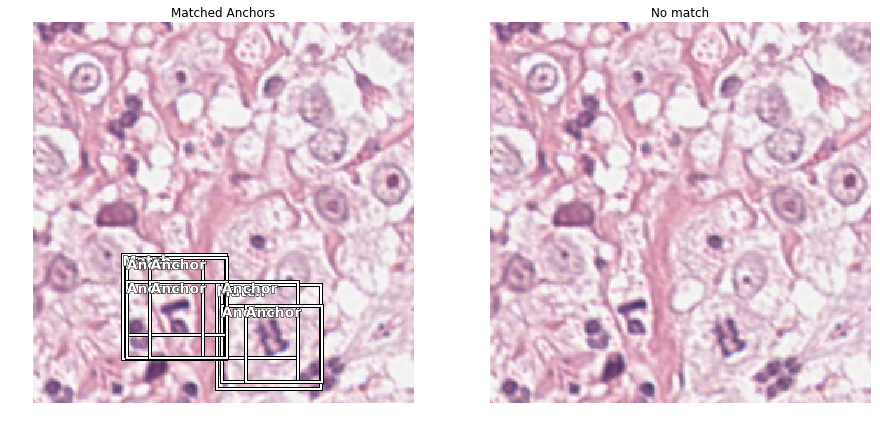

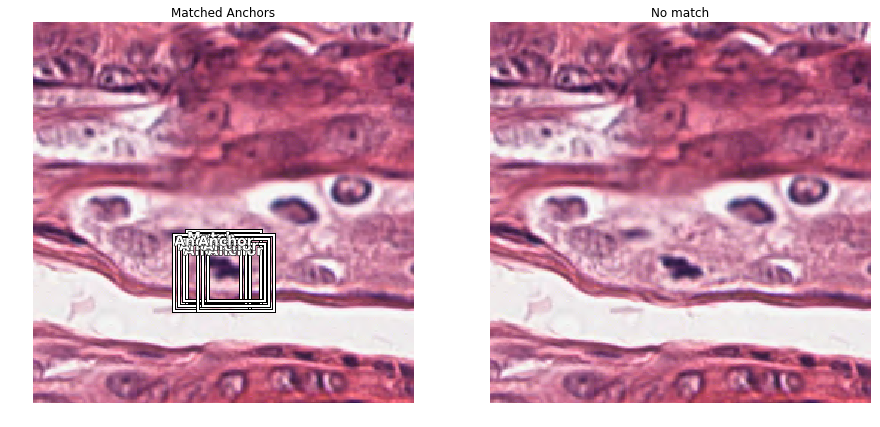

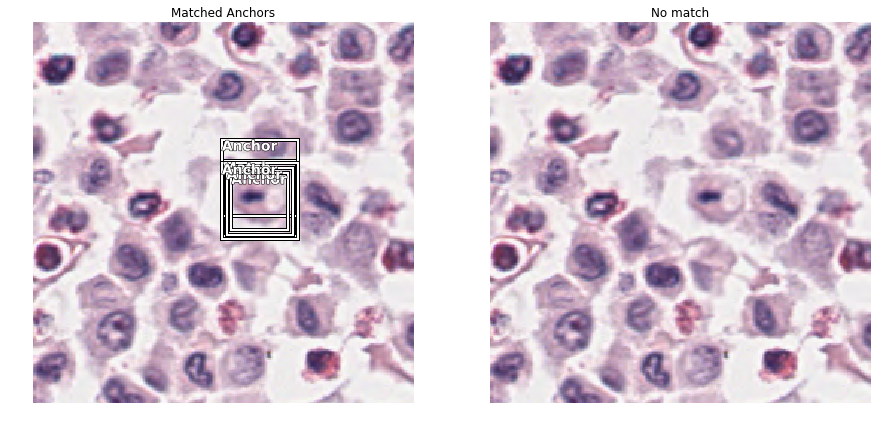

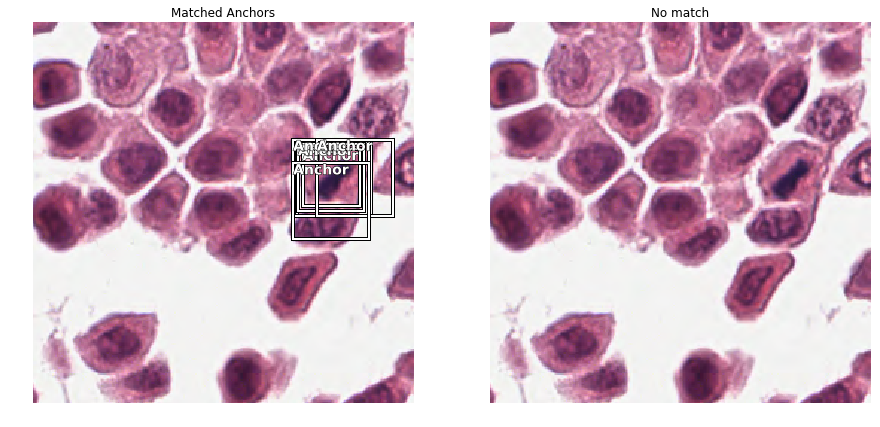

In [6]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])
not_found = show_anchors_on_images(data, anchors)

In [7]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [8]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [9]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


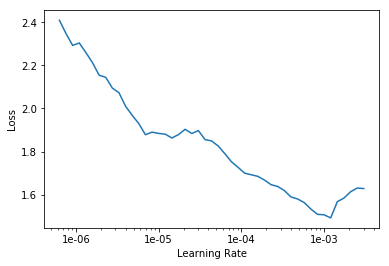

In [10]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1881/1881 [00:00<00:00, 5291.92it/s]


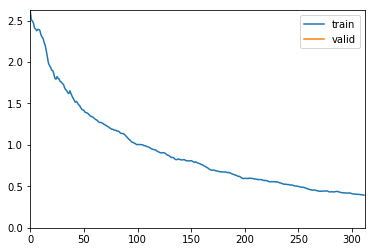

In [11]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 1978/1978 [00:00<00:00, 4864.28it/s]


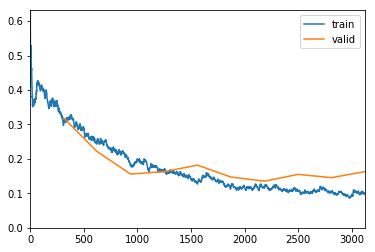

GT: 100%|██████████| 2038/2038 [00:00<00:00, 5261.12it/s]


In [12]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 2167/2167 [00:00<00:00, 5011.28it/s]


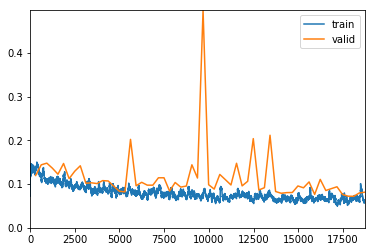

Better model found at epoch 0 with pascal_voc_metric value: 0.7478299947959056.


GT: 100%|██████████| 2023/2023 [00:00<00:00, 5458.62it/s]


Better model found at epoch 1 with pascal_voc_metric value: 0.8114195081819452.


GT: 100%|██████████| 2089/2089 [00:00<00:00, 5285.70it/s]


Better model found at epoch 3 with pascal_voc_metric value: 0.8169147621572503.


GT: 100%|██████████| 2074/2074 [00:00<00:00, 5106.59it/s]


Better model found at epoch 5 with pascal_voc_metric value: 0.8360310821801274.


GT: 100%|██████████| 2120/2120 [00:00<00:00, 5240.92it/s]


Better model found at epoch 10 with pascal_voc_metric value: 0.8598050154878986.


GT: 100%|██████████| 2084/2084 [00:00<00:00, 5415.67it/s]


Better model found at epoch 17 with pascal_voc_metric value: 0.8855552618457059.


GT: 100%|██████████| 2096/2096 [00:00<00:00, 5342.97it/s]


Better model found at epoch 19 with pascal_voc_metric value: 0.8974400393912496.


GT: 100%|██████████| 2101/2101 [00:00<00:00, 5173.38it/s]


Better model found at epoch 20 with pascal_voc_metric value: 0.9028814358205849.


GT: 100%|██████████| 2138/2138 [00:00<00:00, 5001.89it/s]


In [13]:
learn.unfreeze()
lr=1e-4

learn.fit(60, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

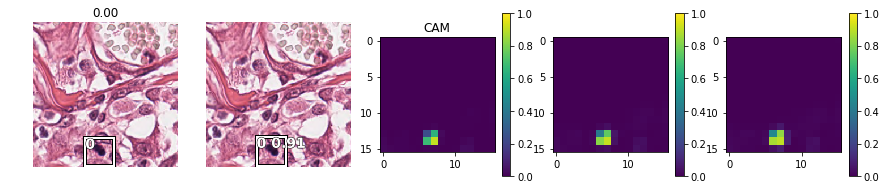

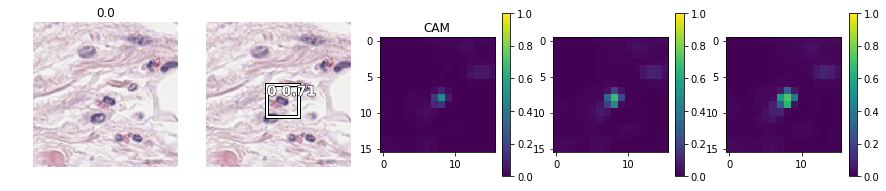

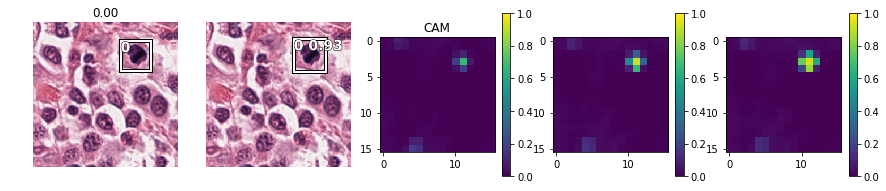

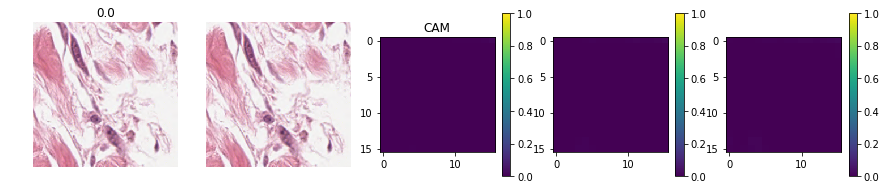

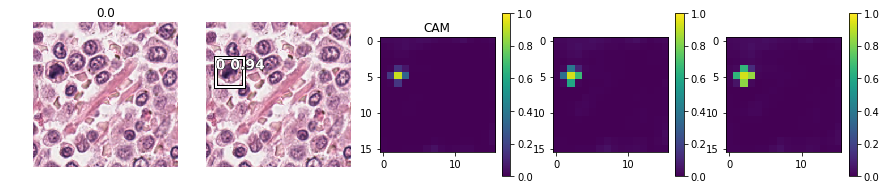

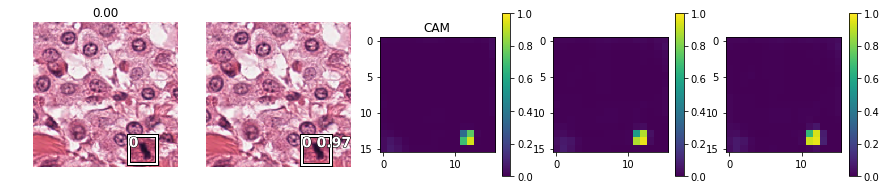

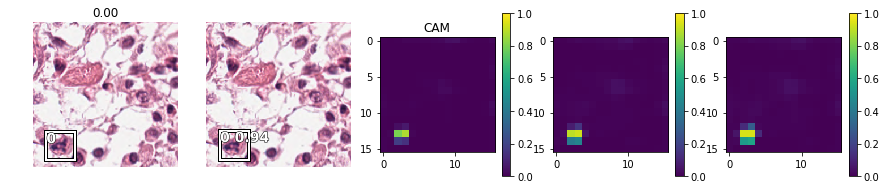

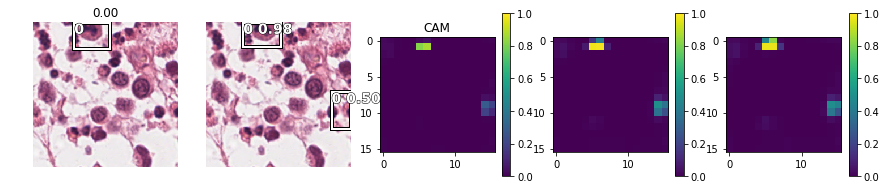

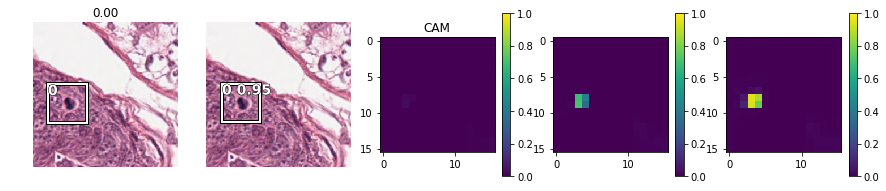

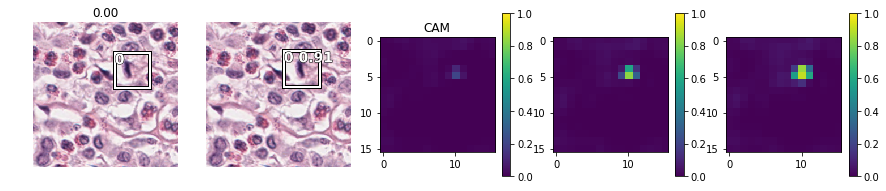

In [14]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [15]:
learn.export("RetinaNet-ODAEL-12WSI-export.pth")